### Merged df that contains annotations and predictions obtained from pretrained Yolov5

In [3]:
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import random

In [4]:
merged_df = pd.read_csv("merged_preds_annotations.csv")
merged_df.head()

,xcenter,ycenter,width_pred,height_pred,confidence,class,name,image,base_filename,class_id,x,y,width_anno,height_anno,class_name,filename
0,0.879586,0.765715,0.239874,0.251582,0.346287,49,orange,386_4_apple_wb_47.jpg,386_4_apple_wb_47,10,0.586640,0.493552,0.826389,0.799603,apple,386_4_apple_wb_47.txt
1,0.587052,0.410899,0.810031,0.572714,0.258975,45,bowl,386_4_apple_wb_47.jpg,386_4_apple_wb_47,10,0.586640,0.493552,0.826389,0.799603,apple,386_4_apple_wb_47.txt
2,0.471107,0.543249,0.682047,0.301719,0.489190,46,banana,208_5_banana_wob_7.jpg,208_5_banana_wob_7,1,0.463624,0.518105,0.700728,0.343750,banana,208_5_banana_wob_7.txt
3,0.476063,0.461047,0.532683,0.113932,0.456632,46,banana,208_5_banana_wob_7.jpg,208_5_banana_wob_7,1,0.463624,0.518105,0.700728,0.343750,banana,208_5_banana_wob_7.txt
4,0.533466,0.607168,0.231547,0.179162,0.582227,49,orange,77_5_apple_wb_29.jpg,77_5_apple_wb_29,10,0.600860,0.532986,0.496032,0.320933,apple,77_5_apple_wb_29.txt


In [24]:
merged_df.loc[merged_df['image'] == "560_6_apple_wb_18.jpg"]

,xcenter,ycenter,width_pred,height_pred,confidence,class,name,image,base_filename,class_id,x,y,width_anno,height_anno,class_name,filename


In [26]:
# Todo: revisar por que faltan predicctions, si esta mal hecho el merge o que
merged_df.base_filename.nunique()

380

Falta aprox predecir la mitad del test set.

In [5]:
%matplotlib inline

### Lets visually compare preds vs ground truth

In [14]:
# convert from YOLO format to corner coordinates
def convert_yolo_to_corners(x_center, y_center, width, height, img_width, img_height):
    xmin = int((x_center - width / 2) * img_width)
    ymin = int((y_center - height / 2) * img_height)
    xmax = int((x_center + width / 2) * img_width)
    ymax = int((y_center + height / 2) * img_height)
    return [xmin, ymin, xmax, ymax]

def show_image_with_bbox_from_df(df, test_path):
    while True:
        # as usual, filter out non-image files  and select a random image
        image_files = [f for f in os.listdir(test_path) if f.endswith(".jpg")]
        
        if not image_files:
            print("No images found in the directory.")
            return

        file_name = random.choice(image_files)
        
        img_path = os.path.join(test_path, file_name)
        img = cv.imread(img_path)
        
        if img is None:
            print(f"Failed to load image: {file_name}")
            continue
        
        # Get image dimensions
        img_height, img_width, _ = img.shape
        
        df_image = df[df['image'] == file_name]
           
        if df_image.empty:
            print(f"No annotations found for image: {file_name}")
            continue
        
        print(f"Selected image: {file_name}")

        # loop through each bounding box in the df
        for _, row in df_image.iterrows():
            pred_box = convert_yolo_to_corners(row['xcenter'], row['ycenter'], row['width_pred'], row['height_pred'], img_width, img_height)
            #print(f"Predicted bbox for {file_name}: {pred_box}")
            cv.rectangle(img, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (255, 0, 0), 7)
            cv.putText(img, f"Pred: {row['name']}", (pred_box[0], pred_box[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 3.5, (255, 0, 0), 2)

            gt_box = convert_yolo_to_corners(row['x'], row['y'], row['width_anno'], row['height_anno'], img_width, img_height)
            #print(f"Ground truth bbox for {file_name}: {gt_box}")
            cv.rectangle(img, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (0, 255, 0), 10)
            cv.putText(img, f"GT: {row['class_name']}", (gt_box[0], gt_box[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 3.5, (0, 255, 0), 10)

        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show(block=True)
        plt.close()
        break

In [15]:
test_path = "/Users/marianata/www/vision_fraud_prevention/dataset_fruits_vegs/test/test"

Selected image: 437_2_tomato_wob_25.jpg


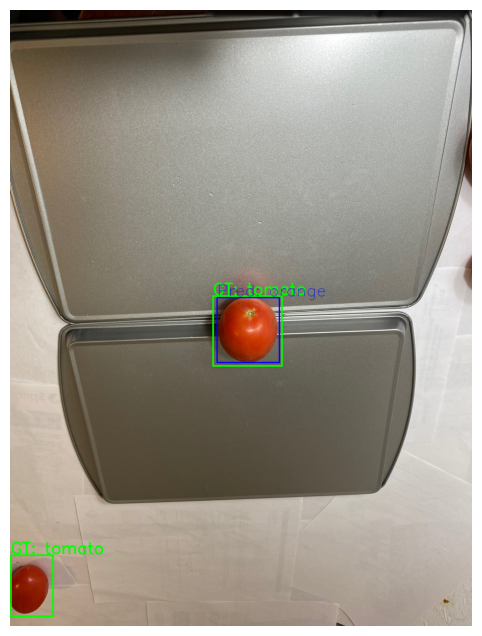

In [40]:
show_image_with_bbox_from_df(merged_df, test_path)

No annotations found for image: 355_4_banana_wb_41.jpg
Selected image: 280_4_lemon_wob_45.jpg


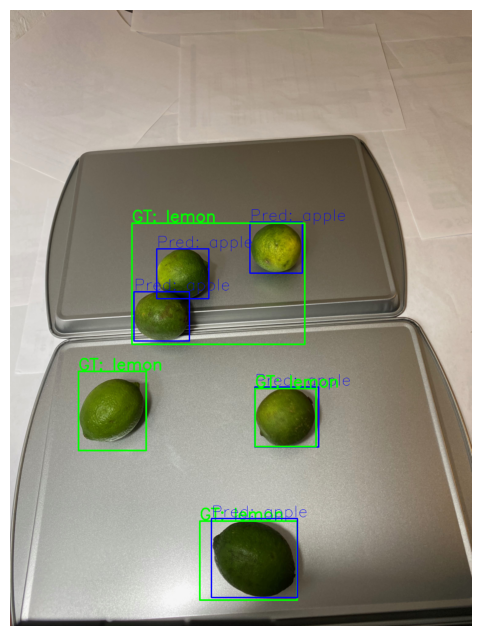

In [54]:
show_image_with_bbox_from_df(merged_df, test_path)

para cada una de las etiquetas de anotacion, ver cuanto esta cubierto de su bounding box por predicciones de la clase corrcta, cuanto esta cubierto por la clase correcta  y cuanto incorrecta?
recall

precision: para cada uno de los cuadrados de prediccion, cual es el overlapping promedio con alguna anotacion de la clase correcta o incorrecta

consulta a profes

Estuve avanzando con el tp, y me tope con lo siguiente:
observo que hay una discrepancia entre las anotaciones de este dataset y el tipo de predicciones que tiene un yolo preentrenado. 
El yolo predice objetos individuales y aca se anotan grupos de objetos.
Mi temor es qe esta discrepancia cause una distorsion en las metricas beneficiando mucho al modelo que yo finetunee con este dataset mas adelante, porque esperarai que un modelo finetuneado empiece a predecir tambien grupos de objetos. 
Como se les ocurre que puedo hacer para medir esto minimizando esta distorsion o para controlarla?


Selected image: 549_0_lemon_wob_14.jpg

sanity check de que el preprocessing sibre las imagnes es que yolo deberia ver
